# COMP579 Assignment 2

**Coding: Tabular RL [70 points]**

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def softmax(x, temp):
    """
    Compute the softmax (Boltzmann) probabilities for action-values x
    given a temperature parameter temp.
    """
    x = np.array(x)
    # subtract maximum for numerical stability
    z = (x - np.max(x)) / temp
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z)

In [ ]:
class Sarsa:
    def __init__(self, env, alpha, gamma, temp):
        self.env = env
        self.alpha = alpha      # learning rate
        self.gamma = gamma      # discount factor
        self.temp = temp        # temperature for softmax exploration
        # Initialize Q-table with one row per state and one column per action
        self.Q = np.zeros((env.observation_space.n, env.action_space.n))

    def select_action(self, s, greedy=False):
        """
        Select an action using softmax exploration (unless greedy is True, then choose argmax).
        """
        if greedy:
            return np.argmax(self.Q[s, :])
        else:
            probs = softmax(self.Q[s, :], self.temp)
            return np.random.choice(np.arange(len(probs)), p=probs)

    def update(self, s, a, r, s_prime, a_prime, done):
        """
        Update Q(s,a) using the SARSA update rule.
        """
        if done:
            target = r
        else:
            target = r + self.gamma * self.Q[s_prime, a_prime]
        self.Q[s, a] += self.alpha * (target - self.Q[s, a])


class ExpectedSarsa:
    def __init__(self, env, alpha, gamma, temp):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.temp = temp
        self.Q = np.zeros((env.observation_space.n, env.action_space.n))

    def select_action(self, s, greedy=False):
        """
        Select an action: greedy if requested, otherwise according to a softmax policy.
        """
        if greedy:
            return np.argmax(self.Q[s, :])
        else:
            probs = softmax(self.Q[s, :], self.temp)
            return np.random.choice(np.arange(len(probs)), p=probs)

    def update(self, s, a, r, s_prime, a_prime, done):
        """
        Update Q(s,a) using the Expected SARSA update rule.
        """
        if done:
            expected_value = 0
        else:
            # Use the current softmax policy on s_prime
            probs = softmax(self.Q[s_prime, :], self.temp)
            expected_value = np.dot(self.Q[s_prime, :], probs)
        target = r + self.gamma * expected_value
        self.Q[s, a] += self.alpha * (target - self.Q[s, a])


# Write your experiment code below

In [ ]:
env_name = 'Taxi-v3'
env = gym.make(env_name)
print("Action space:", env.action_space)
print("State space:", env.observation_space)

Action space: Discrete(6)
State space: Discrete(500)


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
# function that runs each episode
def run_episode(agent, env, training=True):
    """
    Run one episode. If training==True, use the agent’s policy with exploration
    and perform updates. If training==False, act greedily (and do not update).
    Returns the total reward for the episode.
    """
    s = env.reset()
    total_reward = 0

    # choose initial action using the appropriate policy:
    if training:
        a = agent.select_action(s, greedy=False)
    else:
        a = agent.select_action(s, greedy=True)

    done = False
    while not done:
        s_prime, r, done, _ = env.step(a)
        total_reward += r
        if training:
            if done:
                # if episode terminates, update once (a_prime not used)
                agent.update(s, a, r, s_prime, None, done)
                break
            # choose next action (on-policy) and update:
            a_prime = agent.select_action(s_prime, greedy=False)
            agent.update(s, a, r, s_prime, a_prime, done)
            s, a = s_prime, a_prime
        else:
            # In testing, act greedily.
            s = s_prime
            if not done:
                a = agent.select_action(s, greedy=True)
    return total_reward

# function that runs each hyperparameter setting
def run_trial(agent_class, alpha, gamma, temp, num_segments, num_train_eps, env):
    """
    Create an agent with the given hyperparameters and run num_segments segments.
    In each segment, run num_train_eps training episodes then one testing episode.
    Returns two lists (length num_segments): the average training return per segment
    and the testing return per segment.
    """
    agent = agent_class(env, alpha, gamma, temp)
    train_returns = []
    test_returns = []
    for seg in range(num_segments):
        seg_train_rewards = []
        for ep in range(num_train_eps):
            r = run_episode(agent, env, training=True)
            seg_train_rewards.append(r)
        train_returns.append(np.mean(seg_train_rewards))
        # run one testing episode with greedy action selection (no updates)
        test_r = run_episode(agent, env, training=False)
        test_returns.append(test_r)
    return train_returns, test_returns


Running experiments for SARSA...


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


  alpha=0.1, temp=0.1 => Final Train: 7.53, Final Test: 6.80
  alpha=0.1, temp=0.5 => Final Train: 7.96, Final Test: 8.30
  alpha=0.1, temp=1.0 => Final Train: 7.42, Final Test: 7.60
  alpha=0.1, temp=5.0 => Final Train: -168.13, Final Test: -115.80
  alpha=0.3, temp=0.1 => Final Train: 8.13, Final Test: 8.80
  alpha=0.3, temp=0.5 => Final Train: 7.96, Final Test: 7.10
  alpha=0.3, temp=1.0 => Final Train: 7.00, Final Test: 7.60
  alpha=0.3, temp=5.0 => Final Train: -170.93, Final Test: -178.70
  alpha=0.5, temp=0.1 => Final Train: 7.89, Final Test: 7.80
  alpha=0.5, temp=0.5 => Final Train: 8.33, Final Test: 8.00
  alpha=0.5, temp=1.0 => Final Train: 6.85, Final Test: 8.80
  alpha=0.5, temp=5.0 => Final Train: -181.60, Final Test: -157.90
  alpha=0.7, temp=0.1 => Final Train: 8.15, Final Test: 9.20
  alpha=0.7, temp=0.5 => Final Train: 7.75, Final Test: 8.20
  alpha=0.7, temp=1.0 => Final Train: 6.80, Final Test: -13.80
  alpha=0.7, temp=5.0 => Final Train: -177.40, Final Test: -200.0

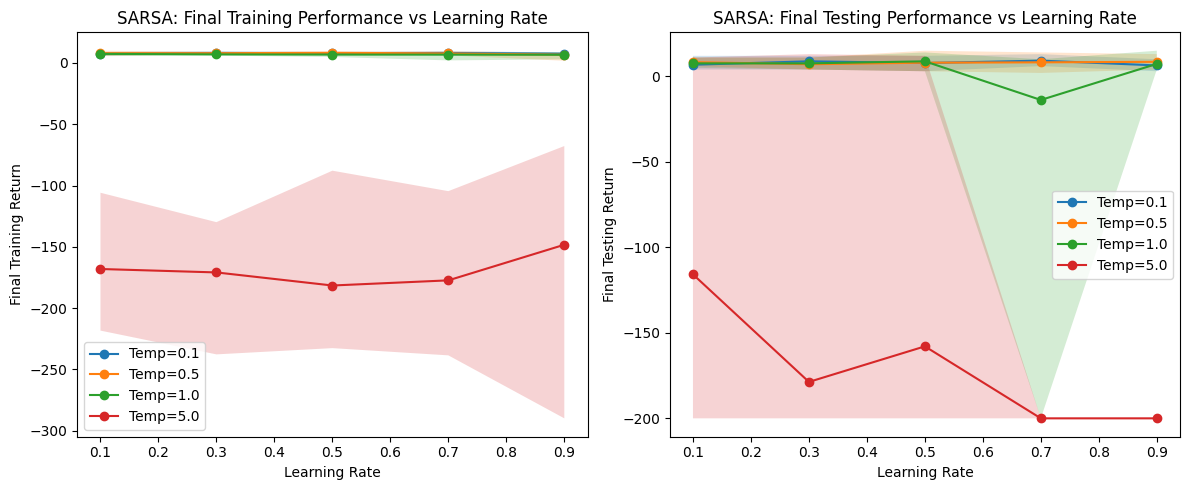

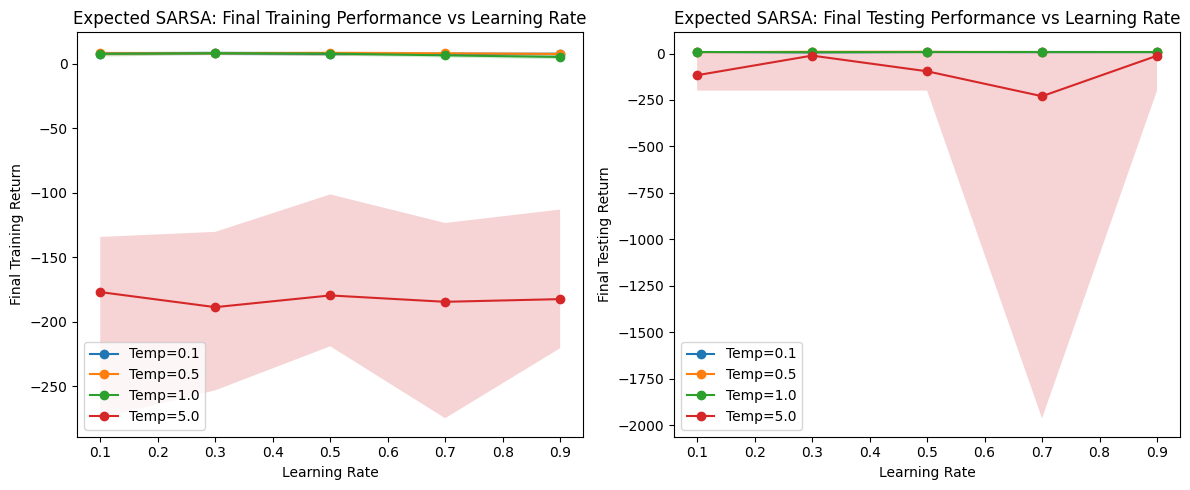

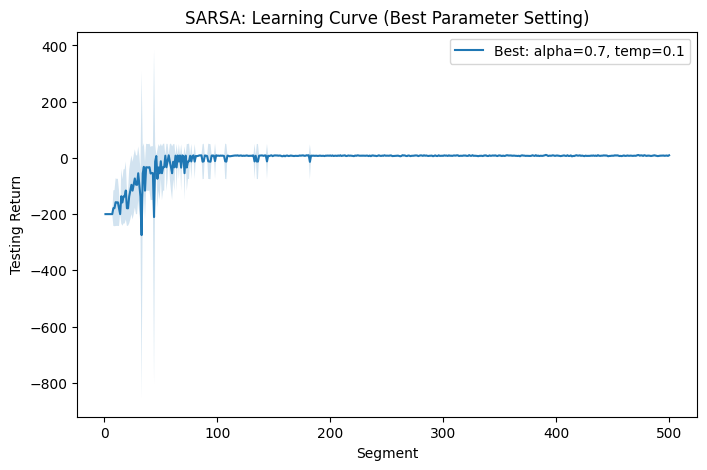

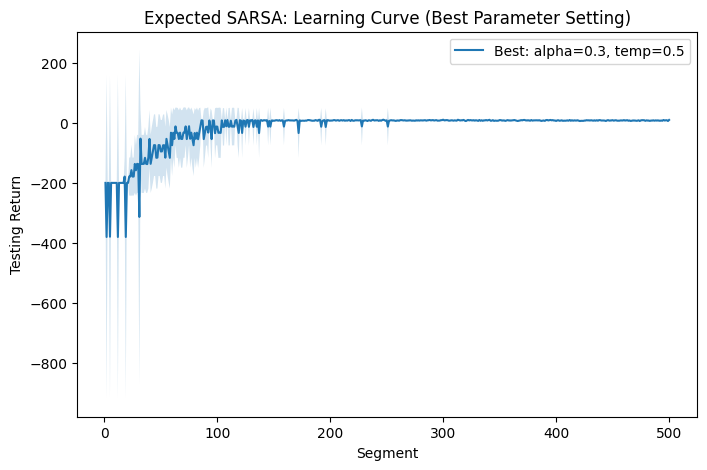

In [ ]:
env_name = 'Taxi-v3'
num_trials = 10            # independent runs for each hyperparameter combo
num_segments = 500         # each trial has 500 segments (5500 episodes total)
num_train_eps = 10         # 10 training episodes per segment
gamma = 0.9                # discount factor

# Define hyperparameter grids.
# (We use 5 learning rates and 4 temperature values; this yields 20 combinations.)
learning_rates = [0.1, 0.3, 0.5, 0.7, 0.9]
temperatures = [0.1, 0.5, 1.0, 5.0]

# We run experiments for two algorithms.
algorithms = {'SARSA': Sarsa, 'Expected SARSA': ExpectedSarsa}
# A dictionary to store results.
# For each algorithm and each (alpha, temp) combo we store:
#  - list of final training returns (the return in the last segment) over trials
#  - list of final testing returns (from the last segment) over trials
#  - learning curves (testing return per segment, per trial)
results = {alg_name: {} for alg_name in algorithms.keys()}

for alg_name, agent_class in algorithms.items():
    print(f"\nRunning experiments for {alg_name}...")
    for alpha in learning_rates:
        for temp in temperatures:
            key = (alpha, temp)
            train_final_all = []
            test_final_all = []
            learning_curves_all = []  # will be an array with shape (num_trials, num_segments)
            for trial in range(num_trials):
                # Create a fresh environment for each trial.
                env = gym.make(env_name)
                train_returns, test_returns = run_trial(agent_class, alpha, gamma, temp, num_segments, num_train_eps, env)
                env.close()
                train_final_all.append(train_returns[-1])
                test_final_all.append(test_returns[-1])
                learning_curves_all.append(test_returns)  # we record test returns as the learning curve
            learning_curves_all = np.array(learning_curves_all)  # shape: (num_trials, num_segments)
            results[alg_name][key] = {
                'train_final': train_final_all,
                'test_final': test_final_all,
                'learning_curves': learning_curves_all
            }
            print(f"  alpha={alpha}, temp={temp} => Final Train: {np.mean(train_final_all):.2f}, Final Test: {np.mean(test_final_all):.2f}")

# --------------------------
# Plot final training and testing performance vs learning rate
# (For each algorithm, we plot curves for different temperature values.)
# --------------------------
for alg_name in algorithms.keys():
    plt.figure(figsize=(12,5))
    # Plot final training performance
    plt.subplot(1,2,1)
    for temp in temperatures:
        avg_train = []
        min_train = []
        max_train = []
        for alpha in learning_rates:
            key = (alpha, temp)
            data = results[alg_name][key]['train_final']
            avg_train.append(np.mean(data))
            min_train.append(np.min(data))
            max_train.append(np.max(data))
        plt.plot(learning_rates, avg_train, marker='o', label=f"Temp={temp}")
        plt.fill_between(learning_rates, min_train, max_train, alpha=0.2)
    plt.xlabel("Learning Rate")
    plt.ylabel("Final Training Return")
    plt.title(f"{alg_name}: Final Training Performance vs Learning Rate")
    plt.legend()

    # Plot final testing performance
    plt.subplot(1,2,2)
    for temp in temperatures:
        avg_test = []
        min_test = []
        max_test = []
        for alpha in learning_rates:
            key = (alpha, temp)
            data = results[alg_name][key]['test_final']
            avg_test.append(np.mean(data))
            min_test.append(np.min(data))
            max_test.append(np.max(data))
        plt.plot(learning_rates, avg_test, marker='o', label=f"Temp={temp}")
        plt.fill_between(learning_rates, min_test, max_test, alpha=0.2)
    plt.xlabel("Learning Rate")
    plt.ylabel("Final Testing Return")
    plt.title(f"{alg_name}: Final Testing Performance vs Learning Rate")
    plt.legend()
    plt.tight_layout()
    plt.show()

# --------------------------
# Plot Learning Curves for Best Parameter Setting for each Algorithm
# (We choose “best” based on the highest average final testing performance.)
# --------------------------
for alg_name in algorithms.keys():
    best_key = None
    best_performance = -np.inf
    # search for the hyperparameter combination with the highest average final test return
    for key, val in results[alg_name].items():
        avg_test_final = np.mean(val['test_final'])
        if avg_test_final > best_performance:
            best_performance = avg_test_final
            best_key = key
    # Compute mean and standard deviation of the learning curve (test return per segment)
    learning_curves = results[alg_name][best_key]['learning_curves']
    mean_curve = np.mean(learning_curves, axis=0)
    std_curve = np.std(learning_curves, axis=0)
    segments = np.arange(1, num_segments + 1)
    plt.figure(figsize=(8,5))
    plt.plot(segments, mean_curve, label=f"Best: alpha={best_key[0]}, temp={best_key[1]}")
    plt.fill_between(segments, mean_curve - std_curve, mean_curve + std_curve, alpha=0.2)
    plt.xlabel("Segment")
    plt.ylabel("Testing Return")
    plt.title(f"{alg_name}: Learning Curve (Best Parameter Setting)")
    plt.legend()
    plt.show()